## Info

Trying to put together a slicker version of the Elastic Nets based on GLMs.

- https://glmnet-python.readthedocs.io/en/latest/glmnet_vignette.html
- https://github.com/bbalasub1/glmnet_python/blob/master/glmnet_python/cvglmnet.py

The elastic net takes arguments for:
- alpha : the regularization parameter (0 is Ridge, 1.0 is Lasso)
- depth : the lambda depth parameter
- lamseq_len : the number of spaces between lamdbda max and lambda min (similar to R elastic net)
- tol : coordinate descent tolerance based on beta convergence
- link : the associated link function (log, identity, etc.) with the fit

<font color=red size=3>**As of 2022-01-24, disabled numba and jit as it doesnt appear to be working properly with dask.**</font>

In [1]:
import pandas as pd
import sidetable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sma

import os
import gc
import shap
import eli5

pd.set_option('max_columns', 150)
pd.set_option('max_rows', 100)

print("TURNING OFF WARNINGS")
import warnings
warnings.filterwarnings(action='ignore')

TURNING OFF WARNINGS


### GLMNet

In [2]:
import GLMNet

### Loading Boston Data

In [3]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

In [4]:
boston = load_boston()
ss = StandardScaler()

Xb = pd.DataFrame(ss.fit_transform(boston['data']), columns=boston['feature_names'])
yb = pd.DataFrame(boston['target'], columns=['target'])

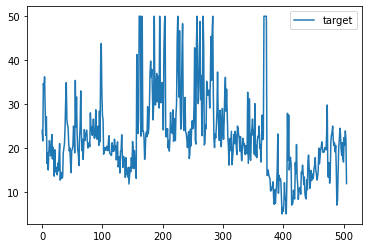

In [5]:
yb.plot();

In [6]:
Xb.shape

(506, 13)

## Gaussian

In [7]:
import time

Estimated Run Time -> 0.10872142314910889


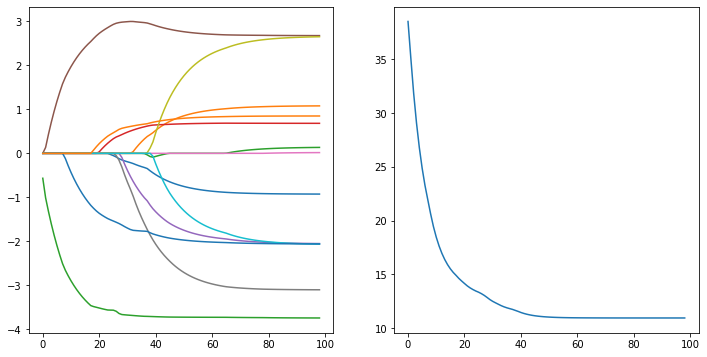

In [8]:
link = 'identity'

st = time.time()
g_test = GLMNet.GaussNet(alpha=0.99, depth=99, lamseq_len=100, tol=1e-12, link=link)
g_test.fit(Xb, yb)
et = time.time()
print(f"Estimated Run Time -> {(et-st)/60}")

fig, ax=plt.subplots(1,2, figsize=(12,6))
ax[0].plot(g_test.B.T);
ax[1].plot(g_test.model_errors);

In [9]:
if 'NegBin' in g_test.family_name:
    fam2 = sma.families.NegativeBinomial()
    link2 = sma.families.links.log()
if 'Gauss' in g_test.family_name:
    fam2 = sma.families.Gaussian()
    link2 = None
if 'Binom' in g_test.family_name:
    fam2 = sma.families.Binomial()
    link2 = sma.families.links.logit()
if 'Poisson' in g_test.family_name:
    fam2 = sma.families.Poisson()
    link2 = sma.families.links.log()

g_sma = sma.GLM(endog=yb, exog=sma.add_constant(Xb), family=fam2, link=link2)
gf = g_sma.fit()
g_pred = gf.predict()
gt_pred = g_test.predict()

my_model = pd.DataFrame(np.append(g_test.B0[:,-1], g_test.B[:,-1], 0), index=['const']+list(Xb.columns))
param_compare = pd.concat([my_model, gf.params.to_frame()], axis=1)
param_compare.columns = ['my_model','statsmodels']
param_compare['diff'] = param_compare.statsmodels - param_compare.my_model
param_compare

,my_model,statsmodels,diff
const,22.532806,22.532806,3.552714e-15
CRIM,-0.926241,-0.928146,-1.904873e-03
ZN,1.078256,1.081569,3.312478e-03
INDUS,0.134477,0.140900,6.423036e-03
CHAS,0.681961,0.681740,-2.212904e-04
NOX,-2.050961,-2.056718,-5.756769e-03
RM,2.675411,2.674230,-1.180335e-03
AGE,0.016465,0.019466,3.000614e-03
DIS,-3.101402,-3.104044,-2.642707e-03
RAD,2.649651,2.662218,1.256630e-02


Pred Error = 0.0044


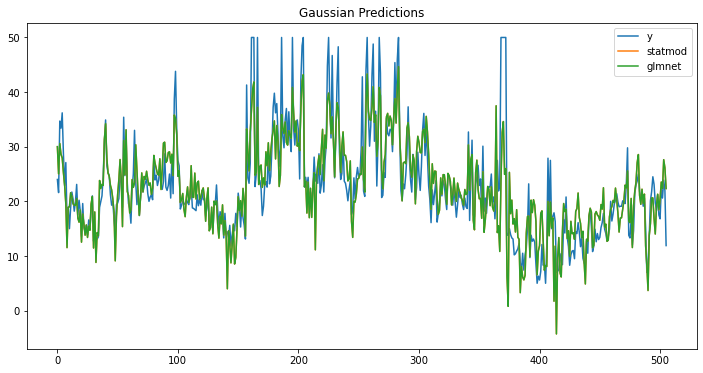

In [10]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
yb.plot(ax=ax)
ax.plot(g_pred)
ax.plot(gt_pred)
ax.legend(['y','statmod','glmnet']);
ax.set_title("Gaussian Predictions");

print("Pred Error = {:.4f}".format(mean_absolute_error(g_pred,gt_pred)))

### Test with different lam seq len...

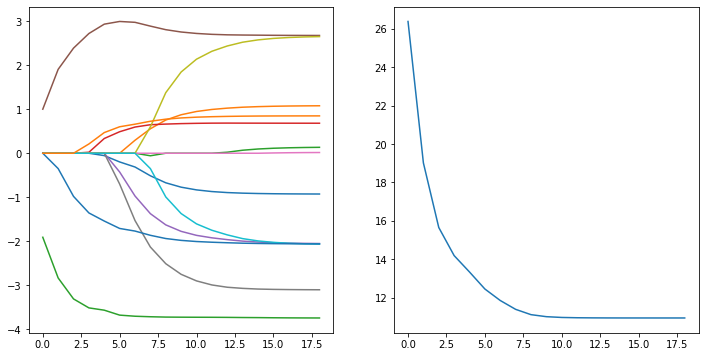

In [13]:
fam = 'Gaussian'
link = 'identity'

g_test = GLMNet.GaussNet(alpha=0.99, depth=19, lamseq_len=20, tol=1e-12, link=link)
g_test.fit(Xb, yb)

fig, ax=plt.subplots(1,2, figsize=(12,6))
ax[0].plot(g_test.B.T);
ax[1].plot(g_test.model_errors);

**We can see the difference in plots here from above based on spacing of the LAMBDAS.**

In [14]:
if 'NegBin' in fam:
    fam2 = sma.families.NegativeBinomial()
    link2 = sma.families.links.log()
if 'Gauss' in fam:
    fam2 = sma.families.Gaussian()
    link2 = None
if 'Binom' in fam:
    fam2 = sma.families.Binomial()
    link2 = sma.families.links.logit()
if 'Poisson' in fam:
    fam2 = sma.families.Poisson()
    link2 = sma.families.links.log()

g_sma = sma.GLM(endog=yb, exog=sma.add_constant(Xb), family=fam2, link=link2)
gf = g_sma.fit()
g_pred = gf.predict()
gt_pred = g_test.predict()

my_model = pd.DataFrame(np.append(g_test.B0[:,-1], g_test.B[:,-1], 0), index=['const']+list(Xb.columns))
param_compare = pd.concat([my_model, gf.params.to_frame()], axis=1)
param_compare.columns = ['my_model','statsmodels']
param_compare['diff'] = param_compare.statsmodels - param_compare.my_model
param_compare

,my_model,statsmodels,diff
const,22.532806,22.532806,3.552714e-15
CRIM,-0.926241,-0.928146,-1.904873e-03
ZN,1.078256,1.081569,3.312478e-03
INDUS,0.134477,0.140900,6.423036e-03
CHAS,0.681961,0.681740,-2.212904e-04
NOX,-2.050961,-2.056718,-5.756769e-03
RM,2.675411,2.674230,-1.180335e-03
AGE,0.016465,0.019466,3.000614e-03
DIS,-3.101402,-3.104044,-2.642707e-03
RAD,2.649651,2.662218,1.256630e-02


## Negative Binomial

Estimated Run Time -> 0.5098052223523458


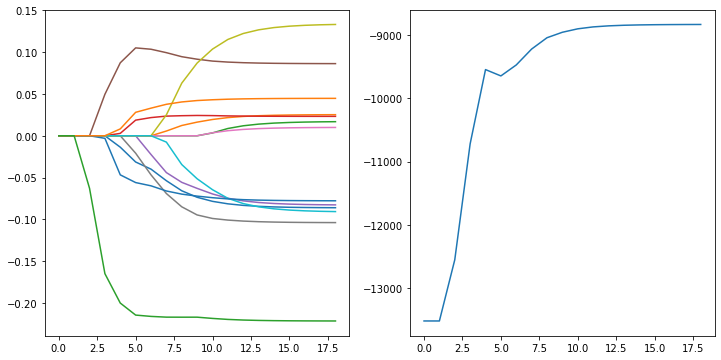

In [16]:
fam = 'NegBin'
link = 'log'

st = time.time()
nb_test = GLMNet.NegBinNet(alpha=0.99, depth=19, lamseq_len=20, tol=1e-12, link=link) 
nb_test.fit(Xb, yb)
et = time.time()
print(f"Estimated Run Time -> {(et-st)/60}")

fig, ax=plt.subplots(1,2, figsize=(12,6))
ax[0].plot(nb_test.B.T);
ax[1].plot(nb_test.model_errors);

In [17]:
if 'NegBin' in fam:
    fam2 = sma.families.NegativeBinomial()
    link2 = sma.families.links.log()
if 'Gauss' in fam:
    fam2 = sma.families.Gaussian()
    link2 = None
if 'Binom' in fam:
    fam2 = sma.families.Binomial()
    link2 = sma.families.links.logit()
if 'Poisson' in fam:
    fam2 = sma.families.Poisson()
    link2 = sma.families.links.log()

nb_sm = sma.GLM(endog=yb, exog=sma.add_constant(Xb), family=fam2, link=link2)
nbf = nb_sm.fit(method='bfgs', maxiter=1000)
nb_pred = nbf.predict()
nbt_pred = nb_test.predict()

my_model = pd.DataFrame(np.append(nb_test.B0[:,-1], nb_test.B[:,-1], 0), index=['const']+list(Xb.columns))
param_compare = pd.concat([my_model, nbf.params.to_frame()], axis=1)
param_compare.columns = ['my_model','statsmodels']
param_compare['diff'] = param_compare.statsmodels - param_compare.my_model
param_compare

,my_model,statsmodels,diff
const,3.049517,3.052433,0.002916
CRIM,-0.086135,-0.086030,0.000104
ZN,0.025241,0.030254,0.005013
INDUS,0.016853,0.015051,-0.001802
CHAS,0.023230,0.027563,0.004333
NOX,-0.082714,-0.097101,-0.014386
RM,0.086353,0.060987,-0.025365
AGE,0.009958,0.006851,-0.003107
DIS,-0.103937,-0.112230,-0.008293
RAD,0.133230,0.132276,-0.000954


**Better error on the NegBin would be an improvement but it is still within convergence.**

Pred Error = 0.5377


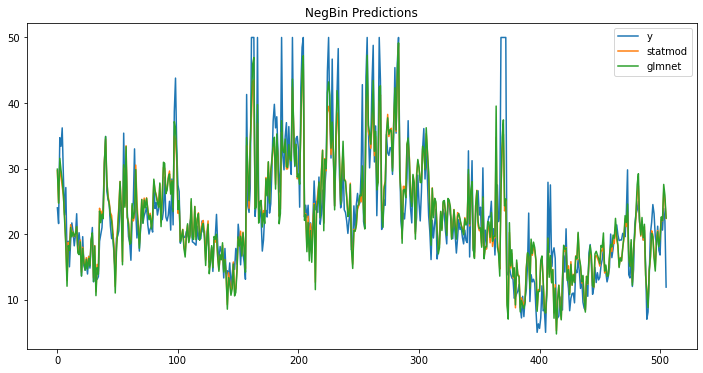

In [18]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
yb.plot(ax=ax)
ax.plot(nb_pred)
ax.plot(nbt_pred)
ax.legend(['y','statmod','glmnet']);
ax.set_title("NegBin Predictions");

print("Pred Error = {:.4f}".format(mean_absolute_error(nb_pred,nbt_pred)))

## Poisson

Estimated Run Time -> 0.05990455150604248


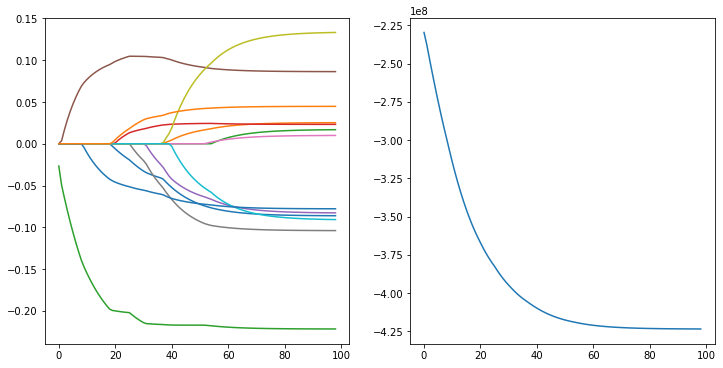

In [19]:
fam = 'Poisson'
link = 'log'

st = time.time()
p_test = GLMNet.PoissonNet(alpha=0.99, depth=99, tol=1e-12, link=link)
p_test.fit(Xb, yb)
et = time.time()
print(f"Estimated Run Time -> {(et-st)/60}")

fig, ax=plt.subplots(1,2, figsize=(12,6))
ax[0].plot(p_test.B.T);
ax[1].plot(p_test.model_errors);

In [20]:
if 'NegBin' in fam:
    fam2 = sma.families.NegativeBinomial()
    link2 = sma.families.links.log()
if 'Gauss' in fam:
    fam2 = sma.families.Gaussian()
    link2 = None
if 'Binom' in fam:
    fam2 = sma.families.Binomial()
    link2 = sma.families.links.logit()
if 'Poisson' in fam:
    fam2 = sma.families.Poisson()
    link2 = sma.families.links.log()

p_sm = sma.GLM(endog=yb, exog=sma.add_constant(Xb), family=fam2, link=link2)
pf = p_sm.fit()
p_pred = pf.predict()
pt_pred = p_test.predict()

my_model = pd.DataFrame(np.append(p_test.B0[:,-1], p_test.B[:,-1], 0), index=['const']+list(Xb.columns))
param_compare = pd.concat([my_model, pf.params.to_frame()], axis=1)
param_compare.columns = ['my_model','statsmodels']
param_compare['diff'] = param_compare.statsmodels - param_compare.my_model
param_compare

,my_model,statsmodels,diff
const,3.049517,3.049483,-0.000034
CRIM,-0.086135,-0.086298,-0.000163
ZN,0.025241,0.025362,0.000121
INDUS,0.016853,0.017135,0.000283
CHAS,0.023230,0.023211,-0.000019
NOX,-0.082714,-0.082990,-0.000276
RM,0.086353,0.086289,-0.000064
AGE,0.009958,0.010093,0.000135
DIS,-0.103937,-0.104041,-0.000105
RAD,0.133230,0.133855,0.000624


**The error on the Poisson is very good.**

Pred Error = 0.0045


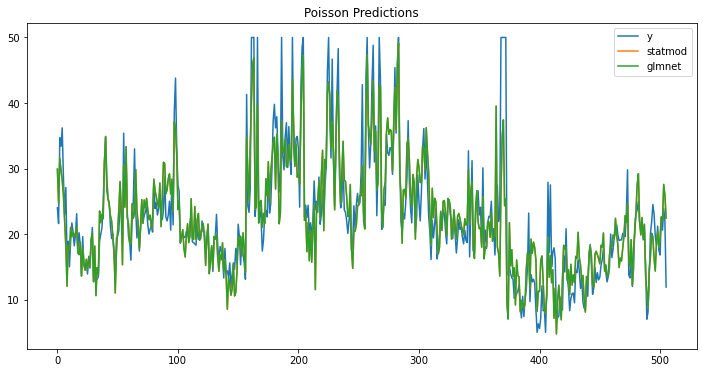

In [21]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
yb.plot(ax=ax)
ax.plot(p_pred)
ax.plot(pt_pred)
ax.legend(['y','statmod','glmnet']);
ax.set_title("Poisson Predictions");

print("Pred Error = {:.4f}".format(mean_absolute_error(p_pred,pt_pred)))

## Binomial with Logit

Estimated Run Time -> 0.10951826572418213


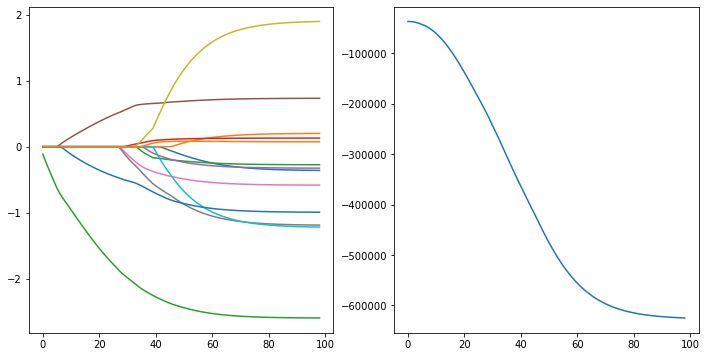

In [22]:
fam = 'Binomial'
link = 'logit'
ybl = np.where(yb > yb.mean(), 1, 0)

st = time.time()
bl_test = GLMNet.BinomialNet(alpha=0.99, depth=99, tol=1e-12, link=link)
bl_test.fit(Xb, ybl)
et = time.time()
print(f"Estimated Run Time -> {(et-st)/60}")

fig, ax=plt.subplots(1,2, figsize=(12,6))
ax[0].plot(bl_test.B.T);
ax[1].plot(bl_test.model_errors);

In [23]:
if 'NegBin' in fam:
    fam2 = sma.families.NegativeBinomial()
    link2 = sma.families.links.log()
if 'Gauss' in fam:
    fam2 = sma.families.Gaussian()
    link2 = None
if 'Binom' in fam:
    fam2 = sma.families.Binomial()
    link2 = sma.families.links.logit()
if 'Poisson' in fam:
    fam2 = sma.families.Poisson()
    link2 = sma.families.links.log()

bl_sma = sma.GLM(endog=ybl, exog=sma.add_constant(Xb), family=fam2, link=link2)
blf = bl_sma.fit()
bl_pred = blf.predict()
blt_pred = bl_test.predict()

my_model = pd.DataFrame(np.append(bl_test.B0[:,-1], bl_test.B[:,-1], 0), index=['const']+list(Xb.columns))
param_compare = pd.concat([my_model, blf.params.to_frame()], axis=1)
param_compare.columns = ['my_model','statsmodels']
param_compare['diff'] = param_compare.statsmodels - param_compare.my_model
param_compare

,my_model,statsmodels,diff
const,-0.983572,-0.984325,-0.000752
CRIM,-0.359463,-0.363492,-0.004029
ZN,0.200890,0.202898,0.002008
INDUS,-0.273421,-0.274273,-0.000853
CHAS,0.130290,0.130402,0.000112
NOX,-0.325151,-0.326274,-0.001122
RM,0.733046,0.733825,0.000779
AGE,-0.582500,-0.583815,-0.001315
DIS,-1.188232,-1.192705,-0.004474
RAD,1.897698,1.907792,0.010094


**THe Binomial with Logit link could be better.**

Pred Error = 0.0002


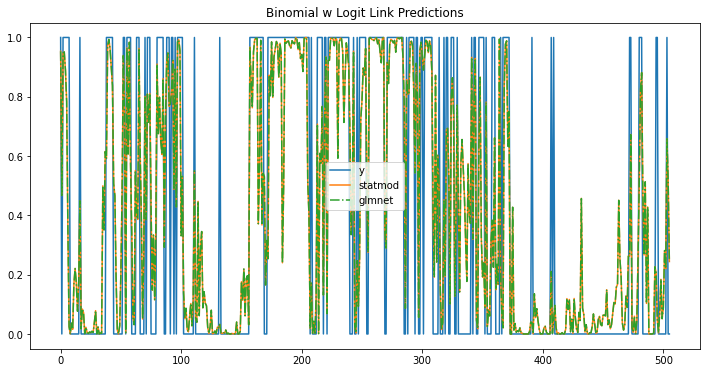

In [24]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
ax.plot(ybl)
ax.plot(bl_pred)
ax.plot(blt_pred, c='C2', ls='-.')
ax.legend(['y','statmod','glmnet']);
ax.set_title("Binomial w Logit Link Predictions");

print("Pred Error = {:.4f}".format(mean_absolute_error(bl_pred,blt_pred)))

## Tweedie

- This is based on Tweedie Compung Poisson Gamma with a power estimate of (1.0,2.0) ie not inclusive.
- We will make a new target that has more zeros, based on the old target.
- Further work is necessary for power optimization.

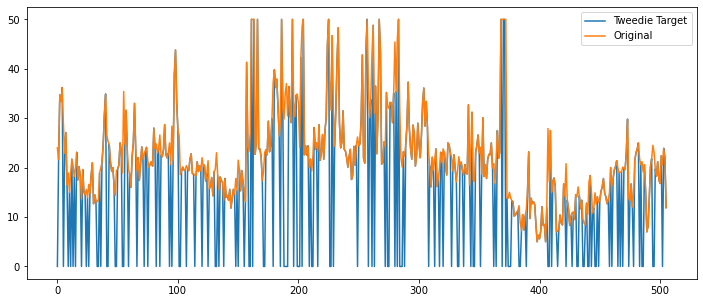

In [25]:
pct_to_zero = 0.25
samp_idx = yb.sample(frac=pct_to_zero, random_state=123).index

fam = 'Tweedie'
link = 'log'
ytwd = yb.copy()
ytwd[ytwd.index.isin(samp_idx)] = 0


fig, ax=plt.subplots(1,1,figsize=(12,5))
ytwd.plot(ax=ax);
yb.plot(ax=ax);
plt.legend(['Tweedie Target','Original']);

In [26]:
(yb==0).sum()/len(yb), (ytwd==0).sum()/len(ytwd)

(target    0.0
 dtype: float64,
 target    0.249012
 dtype: float64)

Estimated Run Time -> 0.07807998259862264


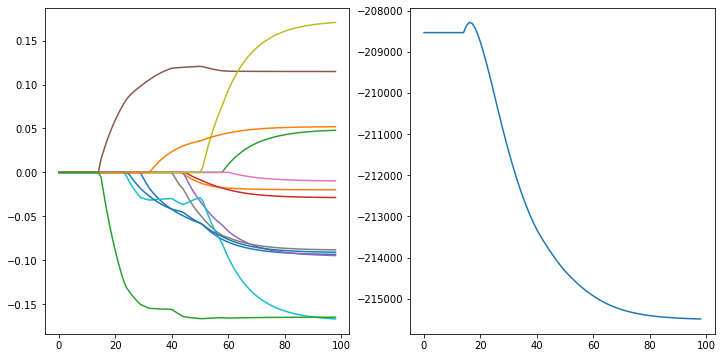

In [27]:
tpower = 1.5
st = time.time()
twd_test = GLMNet.TweedieNet(alpha=0.99, depth=99, tol=1e-12, pwr=1.5, link=link)
twd_test.fit(Xb, ytwd, weights=1)
et = time.time()
print(f"Estimated Run Time -> {(et-st)/60}")

fig, ax=plt.subplots(1,2, figsize=(12,6))
ax[0].plot(twd_test.B.T);
ax[1].plot(twd_test.model_errors);

In [28]:
if 'NegBin' in fam:
    fam2 = sma.families.NegativeBinomial()
    link2 = sma.families.links.log()
if 'Gauss' in fam:
    fam2 = sma.families.Gaussian()
    link2 = None
if 'Binom' in fam:
    fam2 = sma.families.Binomial()
    link2 = sma.families.links.logit()
if 'Poisson' in fam:
    fam2 = sma.families.Poisson()
    link2 = sma.families.links.log()
if 'Tweedie' in fam:
    fam2 = sma.families.Tweedie(var_power=tpower,
                                eql=True if (tpower >=1.0) & (tpower<2.0) else False)
    link2 = sma.families.links.log()

twd_sma = sma.GLM(endog=ytwd, exog=sma.add_constant(Xb), family=fam2, link=link2)
twdf = twd_sma.fit()
twd_pred = twdf.predict()
twdt_pred = twd_test.predict()

my_model = pd.DataFrame(np.append(twd_test.B0[:,-1], twd_test.B[:,-1], 0), index=['const']+list(Xb.columns))
param_compare = pd.concat([my_model, twdf.params.to_frame()], axis=1)
param_compare.columns = ['my_model','statsmodels']
param_compare['diff'] = param_compare.statsmodels - param_compare.my_model

print("Pred Error = {:.4f}".format(mean_absolute_error(bl_pred,blt_pred)))
param_compare

Pred Error = 0.0002


,my_model,statsmodels,diff
const,2.760247,2.760175,-0.000072
CRIM,-0.093364,-0.093782,-0.000418
ZN,-0.019845,-0.019905,-0.000059
INDUS,0.047921,0.049095,0.001173
CHAS,-0.028651,-0.028919,-0.000268
NOX,-0.094690,-0.095524,-0.000833
RM,0.114869,0.114859,-0.000010
AGE,-0.009676,-0.009974,-0.000298
DIS,-0.088232,-0.088653,-0.000422
RAD,0.170695,0.173015,0.002320


**Pretty good.**

Pred Error = 0.0129


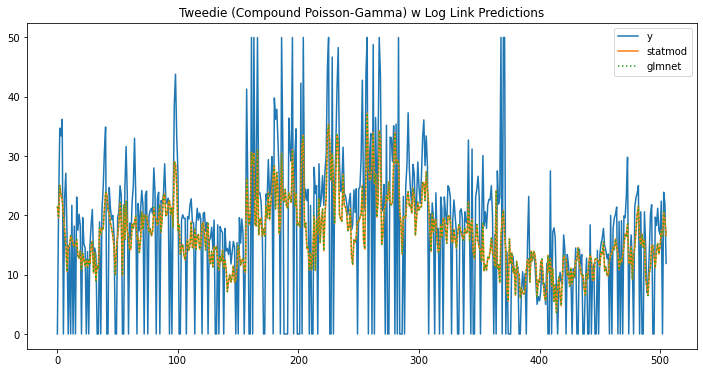

In [29]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
ax.plot(ytwd)
ax.plot(twd_pred)
ax.plot(twdt_pred, c='C2', ls=':')
ax.legend(['y','statmod','glmnet']);
ax.set_title("Tweedie (Compound Poisson-Gamma) w Log Link Predictions");

print("Pred Error = {:.4f}".format(mean_absolute_error(twd_pred,twdt_pred)))

### END

- **Effort is being placed to make these methods compatible with sklearn cross validation methods.**